In [40]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


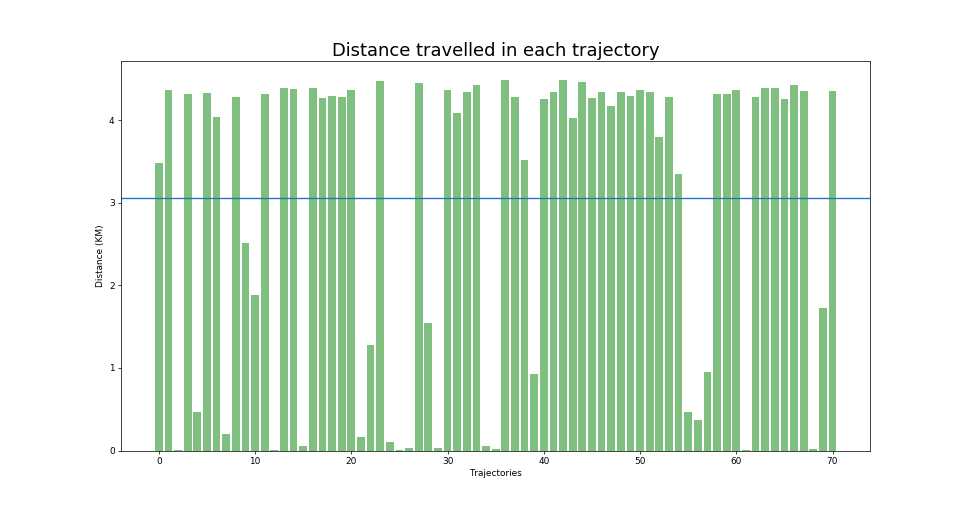

<IPython.core.display.Javascript object>


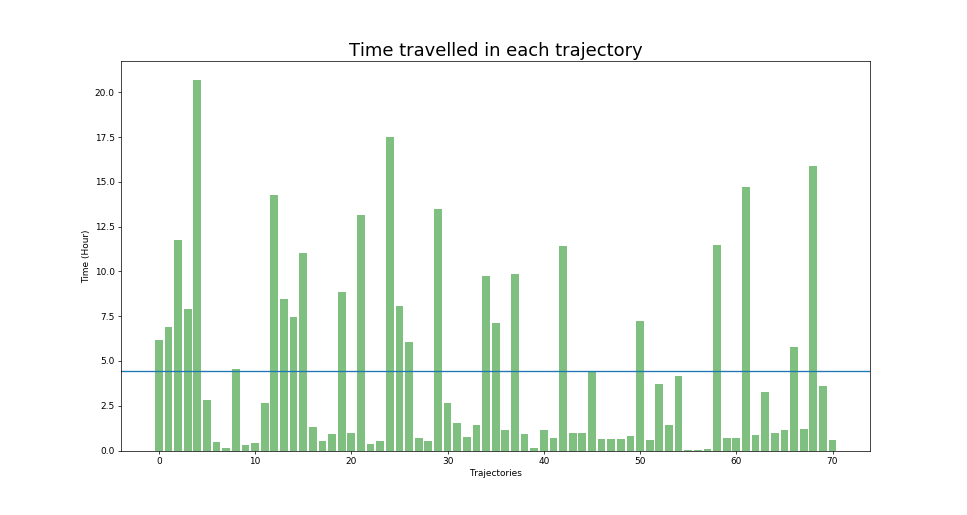

<IPython.core.display.Javascript object>


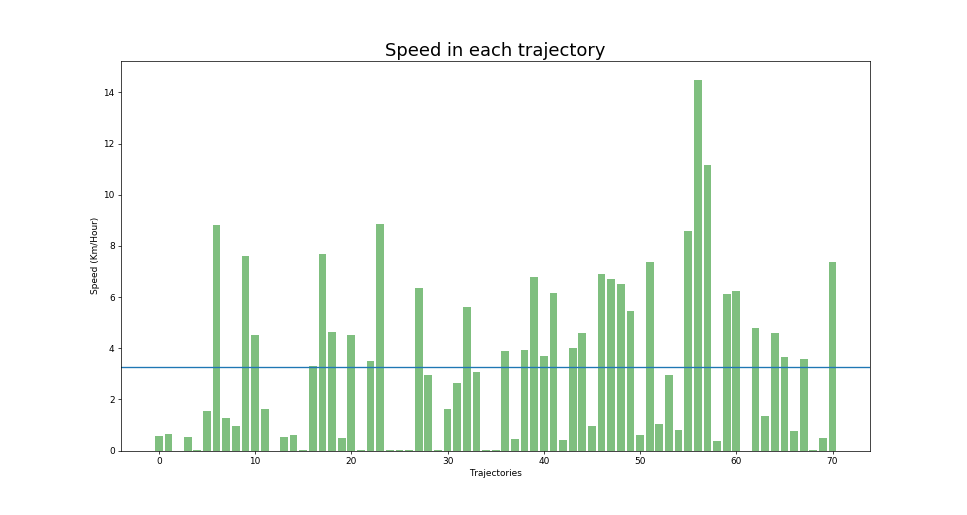

<IPython.core.display.Javascript object>


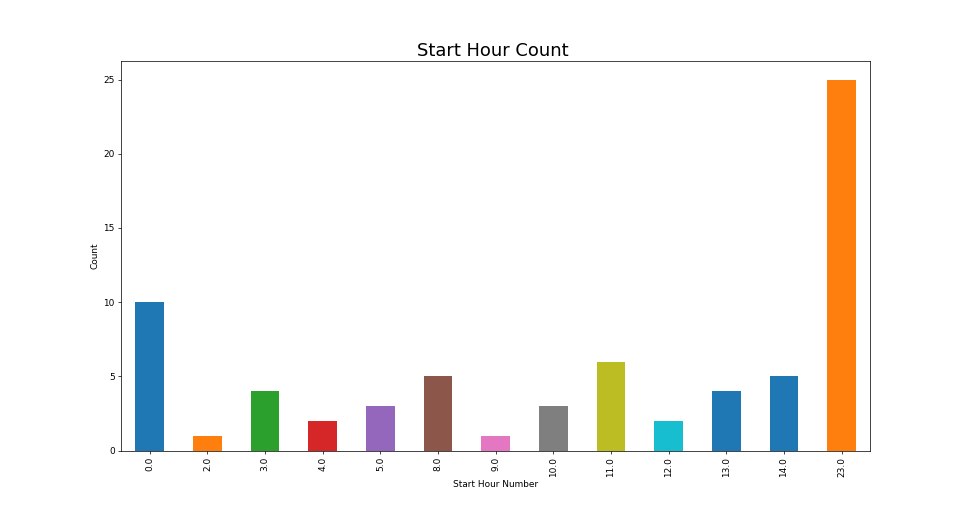

<IPython.core.display.Javascript object>


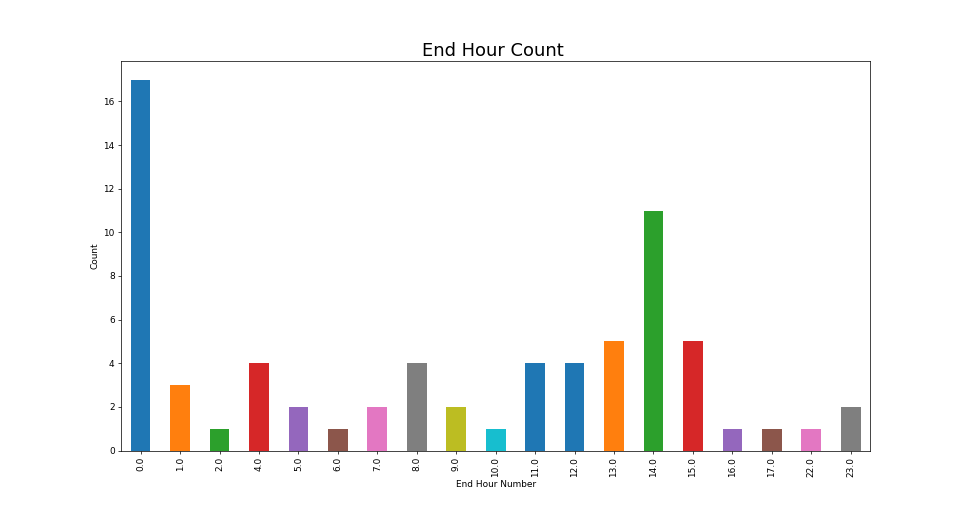

<IPython.core.display.Javascript object>


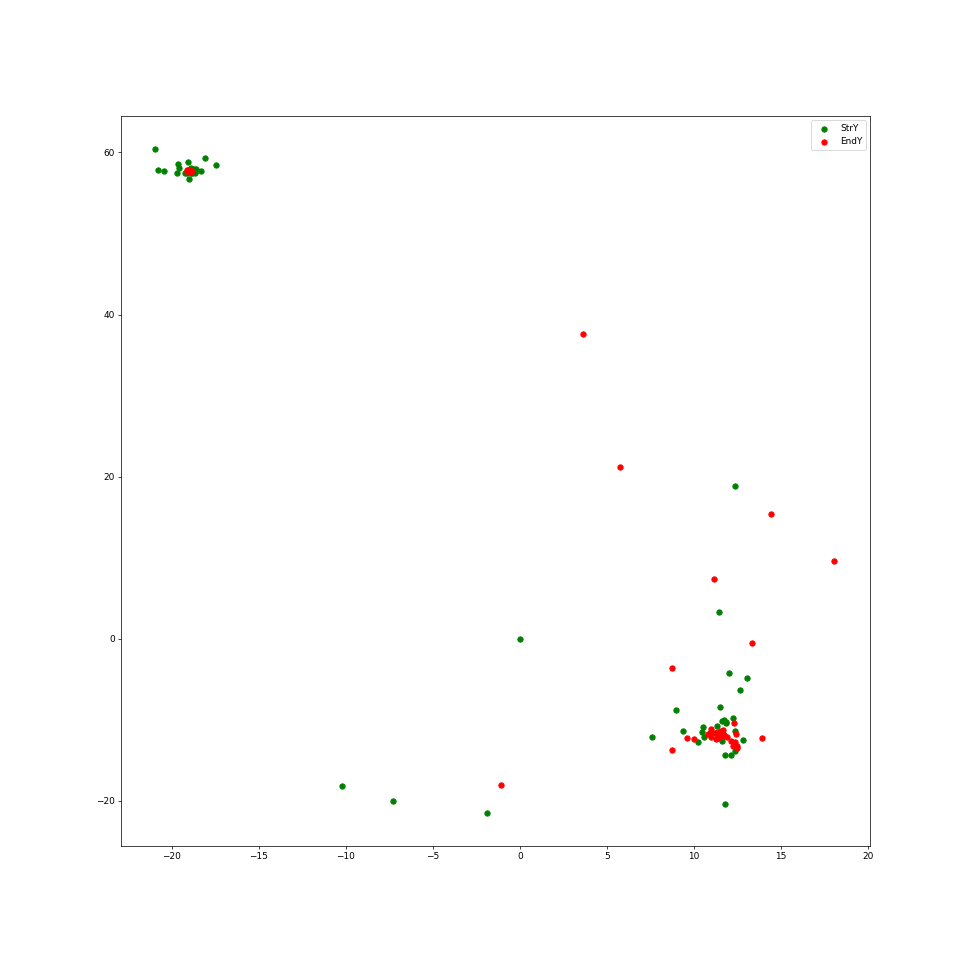

<IPython.core.display.Javascript object>


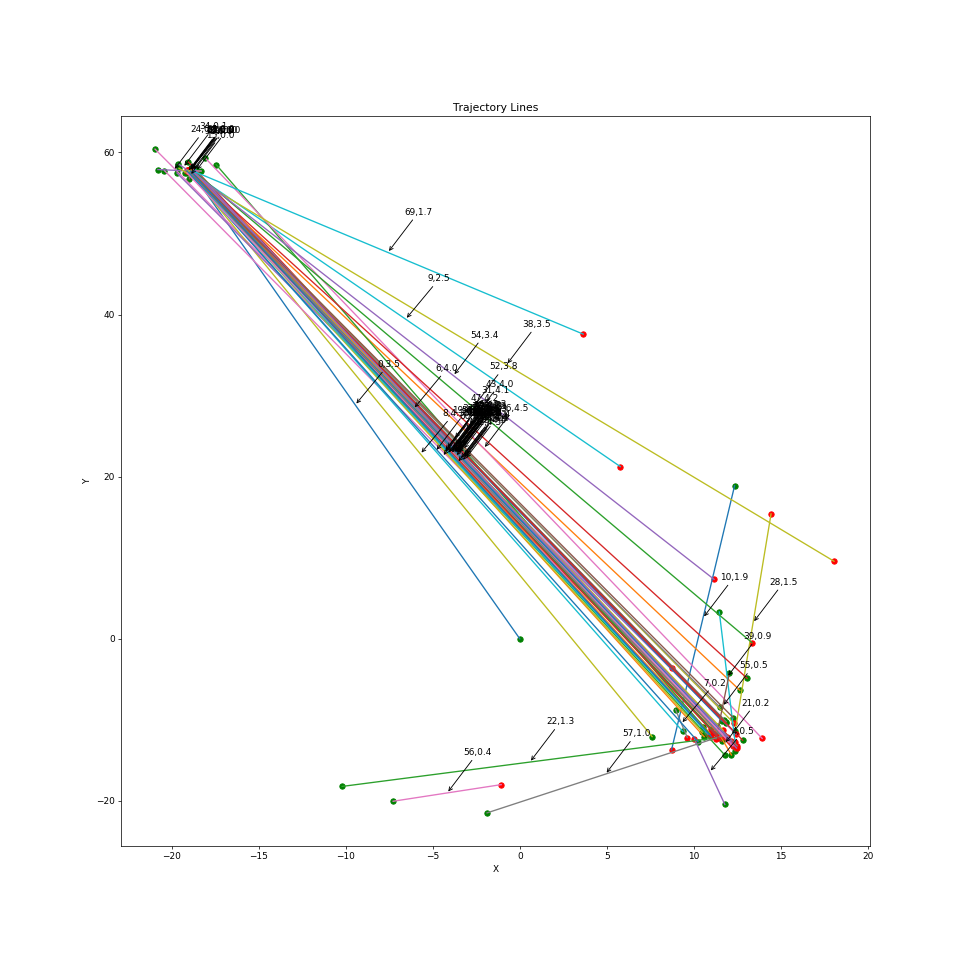

In [19]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import seaborn as sns
import math 
import time
import os
import sys
from ctypes import *
from math import radians, cos, sin, asin, sqrt
%matplotlib inline
%matplotlib nbagg
# import mpld3
# mpld3.enable_notebook()

#Find distance between two lan:lon points in meters
def meters(lat1, lon1, lat2, lon2):  
    R = 6378.137 # Radius of earth in KM
    dLat = lat2 * math.pi / 180 - lat1 * math.pi / 180
    dLon = lon2 * math.pi / 180 - lon1 * math.pi / 180
    a = math.sin(dLat/2) * math.sin(dLat/2) + math.cos(lat1 * math.pi / 180) * math.cos(lat2 * math.pi / 180) * math.sin(dLon/2) * math.sin(dLon/2);
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a));
    d = R * c
    return d * 1000 # meters

def populate_firstlst_pts_df(file_src):
    global firstlst_pts_df
    
    firstlst_pts_df = firstlst_pts_df.iloc[0:0]
    firstlst_pts_df = pd.DataFrame()
    firstlst_pts_df['TrajId'] = 0
    firstlst_pts_df['File'] = 0
    firstlst_pts_df['StrLat'] = 0.0
    firstlst_pts_df['StrLon'] = 0.0
    firstlst_pts_df['EndLat'] = 0.0
    firstlst_pts_df['EndLon'] = 0.0
    firstlst_pts_df['StrX'] = 0.0
    firstlst_pts_df['StrY'] = 0.0
    firstlst_pts_df['EndX'] = 0.0
    firstlst_pts_df['EndY'] = 0.0
    firstlst_pts_df['Dist(km)'] = 0.0
    firstlst_pts_df['Time(hr)'] = 0.0
    firstlst_pts_df['Spd(km/hr)'] = 0.0
    firstlst_pts_df['StrHr'] = 0.0
    firstlst_pts_df['EndHr'] = 0.0
    
    for dirname, dirnames, filenames in os.walk(file_src):
        i = 0
        #import pdb; pdb.set_trace()
        for filename in filenames:
            if  filename.endswith('plt'):

                gpsfile = os.path.join(dirname, filename)
                log = open(gpsfile, 'r')
                points = log.readlines()[6:] # first 6 lines are useless
                pointNum = len(points)
                
                first_point = points[0].rstrip().split(',')
                last_point = points[len(points)-1].rstrip().split(',')
                start_time = first_point[6]
                end_time = last_point[6]
                trj_time = (datetime.strptime(end_time, time_format) - datetime.strptime(start_time, time_format)).seconds/3600

                #import pdb; pdb.set_trace()
                firstlst_pts_df.loc[i, 'File'] = filename
                firstlst_pts_df.loc[i, 'StrLat'] = float(first_point[0])
                firstlst_pts_df.loc[i ,'StrLon'] = float(first_point[1])
                firstlst_pts_df.loc[i, 'EndLat'] = float(last_point[0])
                firstlst_pts_df.loc[i, 'EndLon'] = float(last_point[1])
                
                firstlst_pts_df.loc[i, 'Dist(km)'] =  meters(float(first_point[0]), float(first_point[1]), 
                                                         float(last_point[0]), float(last_point[1])) / 1000
                firstlst_pts_df.loc[i, 'Time(hr)'] = trj_time
                firstlst_pts_df.loc[i, 'Spd(km/hr)'] = ((firstlst_pts_df.loc[i, 'Dist(km)']) / 
                                                        (firstlst_pts_df.loc[i, 'Time(hr)']))
                firstlst_pts_df.loc[i, 'StrHr'] = datetime.strptime(start_time, time_format).hour
                firstlst_pts_df.loc[i, 'EndHr'] = datetime.strptime(end_time, time_format).hour
                i+=1
    
    firstlst_pts_df = firstlst_pts_df.sort_values(['File'])
    firstlst_pts_df = firstlst_pts_df.reset_index(drop=True)
    firstlst_pts_df['TrajId'] = firstlst_pts_df.index
    
    #convert each lat and lon into x and y for the plot w.r.t origin
    EARTH_RAD = 6378100
    
    origin_lat = math.radians(firstlst_pts_df["StrLat"][0])
    origin_lon = math.radians(firstlst_pts_df["StrLon"][0])

    for j in range(0, len(firstlst_pts_df)):
        x = 0
        y = 0
        current_lat = math.radians(firstlst_pts_df["StrLat"][j])
        current_lon = math.radians(firstlst_pts_df["StrLon"][j])
        x = ((math.cos(current_lat) + math.cos(origin_lat))/2) * EARTH_RAD * (current_lon - origin_lon) * math.pi / 180
        y = (current_lat - origin_lat)* math.pi/180 * EARTH_RAD
        firstlst_pts_df.at[j, 'StrX'] = x
        firstlst_pts_df.at[j, 'StrY'] = y
    
#     origin_lat = math.radians(firstlst_pts_df["EndLat"][0])
#     origin_lon = math.radians(firstlst_pts_df["EndLon"][0])

    for j in range(0, len(firstlst_pts_df)):
        x = 0
        y = 0
        current_lat = math.radians(firstlst_pts_df["EndLat"][j])
        current_lon = math.radians(firstlst_pts_df["EndLon"][j])
        x = ((math.cos(current_lat) + math.cos(origin_lat))/2) * EARTH_RAD * (current_lon - origin_lon) * math.pi / 180
        y = (current_lat - origin_lat)* math.pi/180 * EARTH_RAD
        firstlst_pts_df.at[j, 'EndX'] = x
        firstlst_pts_df.at[j, 'EndY'] = y
    
def plot_distance():
    fig, ax = plt.subplots(figsize=(15,8))
    
    x = firstlst_pts_df['TrajId']
    y = firstlst_pts_df['Dist(km)']
    plt.bar(x, y, align='center', alpha=0.5, color='g')
    
    mean = firstlst_pts_df['Dist(km)'].mean()
    ax.axhline(mean)
    ax.set_xlabel("Trajectories")
    ax.set_ylabel("Distance (KM)")
    ax.set_title(("Distance travelled in each trajectory"), fontsize=20)
    plt.show()
def plot_time():
    fig, ax = plt.subplots(figsize=(15,8))
    
    x = firstlst_pts_df['TrajId']
    y = firstlst_pts_df['Time(hr)']
    plt.bar(x, y, align='center', alpha=0.5, color='g')
    
    mean = firstlst_pts_df['Time(hr)'].mean()
    ax.axhline(mean)
    ax.set_xlabel("Trajectories")
    ax.set_ylabel("Time (Hour)")
    ax.set_title(("Time travelled in each trajectory"), fontsize=20)
    plt.show()
def plot_speed():
    fig, ax = plt.subplots(figsize=(15,8))
    
    x = firstlst_pts_df['TrajId']
    y = firstlst_pts_df['Spd(km/hr)']
    plt.bar(x, y, align='center', alpha=0.5, color='g')
    
    mean = firstlst_pts_df['Spd(km/hr)'].mean()
    ax.axhline(mean)
    ax.set_xlabel("Trajectories")
    ax.set_ylabel("Speed (Km/Hour)")
    ax.set_title(("Speed in each trajectory"), fontsize=20)
    plt.show()
def plot_starthour():
    fig, ax = plt.subplots(figsize=(15,8))
    
    strhr = firstlst_pts_df.groupby('StrHr').size()
    strhr.plot.bar()
    
    ax.set_xlabel("Start Hour Number")
    ax.set_ylabel("Count")
    ax.set_title(("Start Hour Count "), fontsize=20)
    plt.show()
def plot_endhour():
    fig, ax = plt.subplots(figsize=(15,8))
    
    strhr = firstlst_pts_df.groupby('EndHr').size()
    strhr.plot.bar()
    
    ax.set_xlabel("End Hour Number")
    ax.set_ylabel("Count")
    ax.set_title(("End Hour Count "), fontsize=20)
    plt.show()
def plot_startend_pts():
    plt.figure(figsize=(15,15))

    plt.scatter(firstlst_pts_df['StrX'],firstlst_pts_df['StrY'], color = 'g')
    plt.scatter(firstlst_pts_df['EndX'],firstlst_pts_df['EndY'], color = 'r')
    plt.legend()
    plt.show()
def plot_trajline():
    
    plt.figure(figsize=(15,15))
    plt.scatter(firstlst_pts_df['StrX'],firstlst_pts_df['StrY'], color = 'g')
    plt.scatter(firstlst_pts_df['EndX'],firstlst_pts_df['EndY'], color = 'r')
    x = firstlst_pts_df[['StrX', 'EndX']]
    y = firstlst_pts_df[['StrY', 'EndY']]
    for i in range(len(firstlst_pts_df)):
        plt.plot(x.iloc[i,:], y.iloc[i,:])
        line_centrex = (firstlst_pts_df.loc[i, 'StrX'] + firstlst_pts_df.loc[i, 'EndX'] )/2
        line_centrey = (firstlst_pts_df.loc[i, 'StrY'] + firstlst_pts_df.loc[i, 'EndY'] )/2
        ant_str = str(firstlst_pts_df.loc[i, 'TrajId']) + "," + str(round(firstlst_pts_df.loc[i, 'Dist(km)'], 1))
        plt.annotate(ant_str, xy=(line_centrex, line_centrey), xycoords='data', 
                     xytext=(50, 50), textcoords='offset points', arrowprops=dict(arrowstyle="->"),
                     horizontalalignment='right', verticalalignment='top')
    plt.title('Trajectory Lines')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()
#------------------------------------------------------------
def main():
    
    i = 1
    user = "%03d"%i
    file_src = file_path + str(user) + '/Trajectory/'

    populate_firstlst_pts_df(file_src)

    plot_distance()

    plot_time()

    plot_speed()

    plot_starthour()

    plot_endhour()

    plot_startend_pts()

    plot_trajline()
#---------------------------------------------------------------
time_format = '%H:%M:%S'
firstlst_pts_df = pd.DataFrame()
file_path = '/home/shashank/Documents/location/Geolife Trajectories 1.3/Data/'

main()